# Proyecto Imágenes Laboratorio Inteligencia

### Profesor: Claudio Pérez
### Auxiliar: Juan Pérez
### Integrantes: Matías Osses - Ignacio - Alejandro

El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR) utilizando distintos métodos de extracción de características. Para el desarrollo de este proyecto debe descargar la base de datos INRIA Holidays dataset. Debe descargar los archivos jpg1.tar.gz y jpg2.tar.gz que contienen imágenes de consulta para 500 clases distintas y las imágenes que deberán ser almacenadas en el buscador, y que están asociadas a esas 500 clases. La figura 1 muestra las principales etapas de un sistema CBIR.


## Importación de librerías

In [2]:
import os
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


## Cálculo de vector de características

In [92]:
class Imagen():
    
    def __init__(self, path):
        self.nombre = path.split('\\')[-1]
        self.img = cv2.imread(path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        #self.img = cv2.resize(self.img, (3264,2448))
        self.histogramas = dict()
        self.asd = dict()
        
    def division(self, n=3):
        nombre = '%sx%s'%(n,n)
        rows, cols, depth = self.img.shape
        histH = []
        histS = []
        histV = []
        div_y = np.linspace(0, rows, n+1).astype(int)
        div_x = np.linspace(0, cols, n+1).astype(int)
        for i, y in enumerate(div_y[1:]):
            for j, x in enumerate(div_x[1:]):
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 0]
                histH.append(np.histogram(celda, bins=8, density = True)[0])
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 1]
                histS.append(np.histogram(celda, bins=12, density = True)[0])
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 2]
                histV.append(np.histogram(celda, bins=3, density = True)[0]) 
                
        self.histogramas[nombre+'_H'] = np.array(histH)
        self.histogramas[nombre+'_S'] = np.array(histS)
        self.histogramas[nombre+'_V'] = np.array(histV)
    
    def divisionNoRectangular(self):
        heigth, width, _ = self.img.shape
        center = (int(width/2), int(heigth/2))
        axis = (int(width/2*0.8), int(heigth/2*0.8))

        #elipse central
        container = np.zeros((heigth,width))
        r1 = (cv2.ellipse(container, center, axis, 0,0, 360, (255,255,255),-1)/255).astype(int)
        #esquina superior izquierda
        container = (container*0).astype(int)
        r2 = (r1 == 0).astype(int) * cv2.rectangle(container, (0,0), center, (255,255,255), -1)
        #esquina superior derecha
        container = (container*0).astype(int)
        r3 = (r1 == 0).astype(int) * cv2.rectangle(container, (int(width/2),0), (width, int(heigth/2) ), (255,255,255), -1)
        #esquina inferior izquierda
        container = (container*0).astype(int)
        r4 = (r1 == 0).astype(int) *  cv2.rectangle(container, (0,int(heigth/2)), (int(width/2), heigth ), (255,255,255), -1)
        #esquina inferior derecha
        container = (container*0).astype(int)
        r5 = (r1 == 0).astype(int) *  cv2.rectangle(container, center, (width,heigth), (255,255,255), -1)    
       
        
        canal = ['H', 'S', 'V']
        bins = [8, 12, 3]
        
        for (n,c,b) in zip(range(3),canal,bins):
            v1 = self.img[:,:,n][r1 > 0]
            v2 = self.img[:,:,n][r2 > 0]
            v3 = self.img[:,:,n][r3 > 0]
            v4 = self.img[:,:,n][r4 > 0]
            v5 = self.img[:,:,n][r5 > 0]
            self.histogramas['reg1_'+c] = np.histogram(v1, bins=b, density = True)[0]
            self.histogramas['reg2_'+c] = np.histogram(v2, bins=b, density = True)[0]
            self.histogramas['reg3_'+c] = np.histogram(v3, bins=b, density = True)[0]
            self.histogramas['reg4_'+c] = np.histogram(v4, bins=b, density = True)[0]
            self.histogramas['reg5_'+c] = np.histogram(v5, bins=b, density = True)[0]
    

    
    def calcularVectorCaracteristicas(self, method):
        if method == 1:
            self.division(3)
        if method == 2:    
            self.division(4)
        if method == 3:
            self.division(6)
        if method == 4:
            self.divisionNoRectangular()
        
        h = np.array([],dtype=int)
        for key in self.histogramas.keys():
            h = np.concatenate([h,self.histogramas[key].reshape(-1)])
        return h

## Distancias

In [4]:
def euclidiana(x,y):
    return np.sqrt(np.sum(x**2+y**2))

def coseno(x,y): 
    num = np.dot(x,y)
    den = np.sqrt((x**2).sum())*np.sqrt((y**2).sum())
    return num/den

def chi_cuadrado(x,y):
    x_t = x.sum()
    y_t = y.sum()
    c = x + y
    x_esperado = x_t*c/(x_t+y_t)
    y_esperado = y_t*c/(x_t+y_t)
    
    return (((x-x_esperado)**2)/x_esperado).sum() + (((y-y_esperado)**2)/y_esperado).sum()
    
def cramer(x,y):
    return(np.sqrt(chi_cuadrado(x,y)/(x.sum() + y.sum())))

## Content Based Image Retrieval (CBIR)

In [318]:

class CBIR():
    
    def __init__(self, distance, method= 1):
        self.distance = distance
        self.database = list()
        self.method = method
    def train(self,X):
        for image in X:
            self.database.append(Imagen(image).calcularVectorCaracteristicas(self.method))
    def evaluar(self,Input):
        self.scores = []
        inc = Imagen(Input).calcularVectorCaracteristicas(self.method)
        for x in self.database:
            self.scores.append(self.distance(inc, x))
        
        

In [7]:
pathj=r'C:\Users\aleja\Desktop\ImagPLIC\jpg1'
a = cv2.imread(pathj+'\\100000.jpg')

In [244]:
c=[] 
for filename in os.listdir(pathj):
    c.append(os.path.join(pathj,filename))

In [198]:
def CalculaTest(path_base):
    X_test=[]#guardara los indices de las imagenes terminadas en 0
    for i in range(len(path_base)):
        value = path_base[i][len(path_base[i])-5:len(path_base[i])-4]
        if value == '0':
            X_test.append(i)
    return X_test
    

In [230]:
def Ordenar_pos(diffarray,distancia):
    np.set_printoptions(suppress=True)
    t=np.arange(len(diffarray))
    ind=np.array([t,diffarray])
    final=np.transpose(ind)
    f_ord=final[np.argsort(final[:, 1])]
    
    if distancia==coseno:
        f_ord=f_ord[::-1] #activar cando sea coseno y desactivar cuando no, lo puedo agregar dps en la función
    
    f_ord=np.transpose(f_ord)
    finaly=list(f_ord[0])
    return finaly

In [237]:
def Calc_R(N,diffarray,Rs):
    rank=0
    for i in range(len(Rs)):
        rank = rank+ 1/N * Rs[i]
    Norm_rank=0
    for i in range(len(Rs)):
        Norm_rank = Norm_rank+ 1/(N*len(diffarray)) * (Rs[i]-N*(N+1)/2)
    return[rank,Norm_rank]

In [332]:

def calculaRanking( database, n_test, distancia, division ):#diffarray:son los scores, image: es el path de la imagen, ranktype tipo de ranking
    
    Test_index=CalculaTest(database)
    
    
    fi2=CBIR(distancia,division)
    fi2.train(database[:100])
    fi2.evaluar(database[Test_index[n_test]])
    
    diffarray=fi2.scores
    
    img_num=Test_index[n_test]
    image=database[img_num]
    path=image[:len(image)-5]
    image_n=image[len(image)-5:len(image)-4]
    
    N=-1 #son todas las adicionales a su clase excluyendo la examinada
    mayores=0
    for i in range(10):
        if os.path.isfile(path+str(i)+'.jpg') == True:
            N += 1
            if int(image_n)<i:
                mayores +=1
                
                
    finaly=Ordenar_pos(diffarray,distancia)
   
    
    Rs=[]#indices
    temporal1=img_num
    for i in range(10):
        if mayores>0:
            temporal1 += 1
            Rs.append(finaly.index(temporal1))
            mayores -= 1
            
    rank,Norm_rank=Calc_R(N,diffarray,Rs)
    
    
    
    cercanas2=finaly[1:11]
    plt.imshow(cv2.imread(database[img_num])[:,:,[2,1,0]])    
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    
    fig=plt.figure(figsize=(12, 12))
    columns = 4
    rows = 3
    for i in range(len(cercanas2)):
        img = cv2.imread(database[int(cercanas2[i])])[:,:,[2,1,0]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()

        
    print('The normal ranking is ' + str(rank) + ' and the normalized rank is ' + str(abs(Norm_rank))) 
    print(cercanas2)

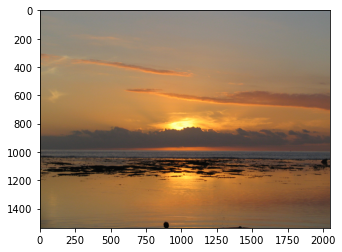

<Figure size 720x720 with 0 Axes>

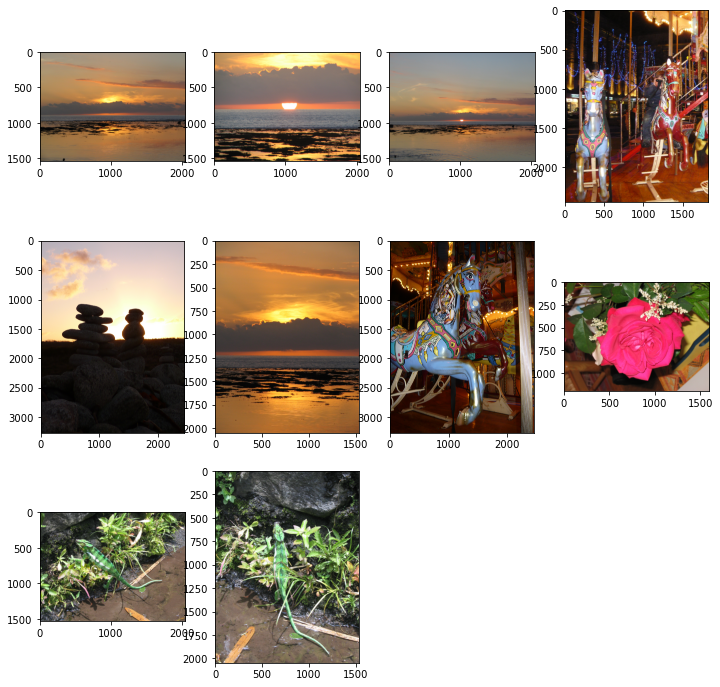

The normal ranking is 3.0 and the normalized rank is 0.07
[35.0, 37.0, 36.0, 17.0, 22.0, 34.0, 16.0, 29.0, 59.0, 60.0]


In [333]:
calculaRanking(c,14,chi_cuadrado,4)

In [325]:
def calculaRanking3( diffarray,database, n_test, distancia, division ):#diffarray:son los scores, image: es el path de la imagen, ranktype tipo de ranking
    
    Test_index=CalculaTest(database)
    
    
    img_num=Test_index[n_test]
    image=database[img_num]
    path=image[:len(image)-5]
    image_n=image[len(image)-5:len(image)-4]
    
    N=-1 #son todas las adicionales a su clase excluyendo la examinada
    mayores=0
    for i in range(10):
        if os.path.isfile(path+str(i)+'.jpg') == True:
            N += 1
            if int(image_n)<i:
                mayores +=1
                
                
    finaly=Ordenar_pos(diffarray,distancia)
   
    
    Rs=[]#indices
    temporal1=img_num
    for i in range(10):
        if mayores>0:
            temporal1 += 1
            Rs.append(finaly.index(temporal1))
            mayores -= 1
      
    rank,Norm_rank=Calc_R(N,diffarray,Rs)
    return(abs(Norm_rank))
    

In [319]:

fi2=CBIR(chi_cuadrado,4)
fi2.train(c)


In [255]:
Indic=CalculaTest(c)

In [340]:
SumR=0
for i in range(len(Indic)):
    fi2.evaluar(c[Indic[i]])
    i0=fi2.scores
    R=calculaRanking3(i0,c,i,chi_cuadrado,4)
    SumR = SumR + R

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [343]:
PromNR=SumR/len(Indic)
PromNR#promedio zona no rectangular

0.16928792647327107

In [344]:
fi3=CBIR(chi_cuadrado,3)
fi3.train(c)

In [350]:
SumR3=0
for i in range(len(Indic)):
    fi3.evaluar(c[Indic[i]])
    i03=fi3.scores
    R=calculaRanking3(i03,c,i,chi_cuadrado,3)
    SumR3 = SumR3 + R

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [351]:
Prom3=SumR3/len(Indic)
Prom3#promedio zona 6x6

0.2718338920817367

In [347]:
fi22=CBIR(chi_cuadrado,2)
fi22.train(c)

In [348]:
SumR22=0
for i in range(len(Indic)):
    fi22.evaluar(c[Indic[i]])
    i022=fi22.scores
    R=calculaRanking3(i022,c,i,chi_cuadrado,2)
    SumR22 = SumR22 + R

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [349]:
Prom22=SumR22/len(Indic)
Prom22#promedio zona 4x4

0.20795323617952916

In [352]:
fi1=CBIR(chi_cuadrado,1)
fi1.train(c)

In [353]:
SumR1=0
for i in range(len(Indic)):
    fi1.evaluar(c[Indic[i]])
    i01=fi1.scores
    R=calculaRanking3(i01,c,i,chi_cuadrado,1)
    SumR1 = SumR1 + R

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [354]:
Prom1=SumR1/len(Indic)
Prom1#promedio zona 3x3

0.16254564632366342